In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scanpy as sc,anndata as ad
import squidpy as sq
import os
import re
import sys
import matplotlib as mpl

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from colorsys import hls_to_rgb

In [3]:
def get_leverage_index(adata,fraction = 0.1,score_column="gene_score",seed = 0):
    #print("running leverage sampling")
    np.random.seed(seed)

    if score_column not in adata.obs:
        raise ValueError(f"Column '{score_column}' not found in adata.obs")

    scores = adata.obs[score_column].values
    # scores = np.clip(scores, a_min=0, a_max=None)  # Ensure no negative values
    probabilities = scores / scores.sum()  # Normalize to get probabilities

    num_cells = adata.n_obs
    sample_size = int(num_cells * fraction)

    sampled_indices = np.random.choice(adata.n_obs, size=sample_size, replace=False, p=probabilities)
    return sorted(list(sampled_indices))

def create_leverage_index_dataframe(adata, fraction=0.1, num_seeds=10, start_seed=0):
    """
    Creates a DataFrame where each column contains the sorted indices from uniform_index
    for a different random seed.
    
    Args:
        adata: AnnData object to sample from
        fraction (float): Fraction of cells to sample
        num_seeds (int): Number of different seeds to use
        start_seed (int): Starting seed value
        
    Returns:
        pandas.DataFrame: DataFrame with columns named 'seed_{seed}' containing sorted indices
    """
    # Dictionary to store results
    results = {}
    
    # Run uniform_index for each seed
    for seed in range(start_seed, start_seed + num_seeds):
        column_name = f'seed_{seed}'
        indices = get_leverage_index(adata, fraction=fraction, seed=seed)
        results[column_name] = indices
    
    # Create DataFrame from results
    # Note: Columns might have different lengths, so we'll use a different approach
    df_dict = {}
    
    # Find the maximum length of any index list
    max_length = max(len(indices) for indices in results.values())
    
    # Pad shorter lists with NaN values
    for column_name, indices in results.items():
        # Pad with NaN if needed
        padded_indices = indices + [np.nan] * (max_length - len(indices))
        df_dict[column_name] = padded_indices
    
    # Create DataFrame
    result_df = pd.DataFrame(df_dict)
    
    return result_df

def uniform_sample_adata(adata, fraction=0.1, random_state=None):
    """
    Uniformly samples a fraction of cells from an AnnData object.
    
    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample (default is 10%)
    - random_state: int, random seed for reproducibility (default is None)
    
    Returns:
    - AnnData object with sampled cells
    """
    print("running uniform sampling")
    np.random.seed(random_state)
    num_cells = adata.n_obs  # Total number of cells
    sample_size = int(num_cells * fraction)  # Compute number of cells to sample

    sampled_indices = np.random.choice(adata.obs.index, size=sample_size, replace=False)
    
    return adata[sampled_indices].copy()  # Return a new AnnData object

def compute_cell_type_proportions_annoy(subset_adata, full_adata, ground_truth="Cell_Type", k=20, n_trees=10):
    """
    Computes the proportion of cell types in the neighborhood of each cell using Annoy.

    Parameters:
    - subset_adata: AnnData object with spatial coordinates for the subset dataset in `subset_adata.obsm`
    - full_adata: AnnData object representing the full dataset with all possible cell types
    - k: Number of nearest neighbors to consider
    - n_trees: Number of trees for Annoy (higher = better accuracy but slower)

    Returns:
    - A DataFrame of shape (n_cells, n_cell_types) with proportions of each cell type in its neighborhood, aligned with full dataset cell types.
    """
    # Extract spatial coordinates from subset adata
    coords = subset_adata.obsm["spatial"]
    n_cells, n_dims = coords.shape

    # Build Annoy index
    annoy_index = AnnoyIndex(n_dims, metric='euclidean')
    for i in range(n_cells):
        annoy_index.add_item(i, coords[i])
    annoy_index.build(n_trees)  # Build the index

    # Extract cell type labels from full adata
    full_cell_types = np.array(full_adata.obs[ground_truth])
    full_unique_types = np.unique(full_cell_types)  # Full unique cell types
    type_to_idx = {t: i for i, t in enumerate(full_unique_types)}  # Mapping cell type to column index

    # Initialize output matrix
    proportions = np.zeros((n_cells, len(full_unique_types)))

    # Extract cell type labels from subset adata
    subset_cell_types = np.array(subset_adata.obs[ground_truth])

    # Compute kNN for each cell in subset adata
    for i in range(n_cells):
        neighbors = annoy_index.get_nns_by_item(i, k+1)[1:]  # Exclude self
        neighbor_types = subset_cell_types[neighbors]  # Get cell types of kNN
        # Count occurrences of each cell type
        for t in neighbor_types:
            proportions[i, type_to_idx[t]] += 1
        proportions[i] /= k  # Normalize to proportions

    # Convert to DataFrame with full unique cell types as columns
    prop_df = pd.DataFrame(proportions, columns=full_unique_types, index=subset_adata.obs.index)
    return prop_df


def compare_cell_type_proportions(matrix1, matrix2):
    """
    Computes cosine similarity, Jensen-Shannon Divergence (JSD), Mean Squared Error (MSE),
    and Frobenius norm between two cell type proportion matrices.

    Parameters:
    - matrix1: pandas DataFrame (n_cells x n_cell_types), first cell type proportion matrix
    - matrix2: pandas DataFrame (n_cells x n_cell_types), second cell type proportion matrix

    Returns:
    - results: dict with 'mean_cosine_similarity', 'mean_jsd', 'mse', and 'frobenius_norm'
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Both matrices must have the same shape.")
    
    # Initialize results with NaN
    results = {
        "mean_cosine_similarity": np.nan,
        "mean_jsd": np.nan,
        "mse": np.nan,
        "frobenius_norm": np.nan
    }

    # Compute Cosine Similarity (mean across all cells) and handle memory issues
    try:
        cos_sim = cosine_similarity(matrix1, matrix2)
        results["mean_cosine_similarity"] = np.mean(np.diag(cos_sim))  # Take mean of diagonal elements (self-similarity)
    except MemoryError:
        print("MemoryError encountered during cosine similarity calculation. Calculating manually.")
        try:
            cos_sim_values = []
            for i in range(matrix1.shape[0]):
                vec1 = matrix1.iloc[i].values
                vec2 = matrix2.iloc[i].values
                dot_product = np.dot(vec1, vec2)
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                
                if norm1 > 0 and norm2 > 0:
                    cos_sim_values.append(dot_product / (norm1 * norm2))
                else:
                    cos_sim_values.append(0)  # Handle zero vector case
            
            results["mean_cosine_similarity"] = np.mean(cos_sim_values)
        except Exception as e:
            print(f"An unexpected error occurred during manual cosine similarity calculation: {e}")

    # Compute Jensen-Shannon Divergence (JSD) and handle memory issues
    try:
        jsd_values = [jensenshannon(matrix1.iloc[i], matrix2.iloc[i]) for i in range(len(matrix1))]
        results["mean_jsd"] = np.mean(jsd_values)
    except MemoryError:
        print("MemoryError encountered during JSD calculation. Returning NaN.")
    except Exception as e:
        print(f"An unexpected error occurred during JSD calculation: {e}")

    # Compute Mean Squared Error (MSE) and handle memory issues
    try:
        results["mse"] = mean_squared_error(matrix1, matrix2)
    except MemoryError:
        print("MemoryError encountered during MSE calculation. Returning NaN.")
    except Exception as e:
        print(f"An unexpected error occurred during MSE calculation: {e}")

    # Compute Frobenius Norm and handle memory issues
    try:
        results["frobenius_norm"] = norm(matrix1.values - matrix2.values, 'fro')
    except MemoryError:
        print("MemoryError encountered during Frobenius Norm calculation. Returning NaN.")
    except Exception as e:
        print(f"An unexpected error occurred during Frobenius Norm calculation: {e}")

    return results



def compute_neighborhood_metrics(adata, fraction=0.1, seed=0, k=20, ground_truth="Cell_Type", n_trees=10):
    """
    Evaluates four sampling methods by computing cell type proportions and comparing them to the full dataset.

    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample
    - seed: int, random seed for reproducibility
    - k: int, number of nearest neighbors for Annoy
    - ground_truth: str, column in `adata.obs` containing cell type labels
    - n_trees: int, number of trees for Annoy index

    Returns:
    - A DataFrame containing similarity metrics for each sampling method
    """
    start_time = time.time()
    # Compute full dataset cell type proportions
    print("Computing cell type proportions for full dataset...")
    cell_type_proportions_full = compute_cell_type_proportions_annoy(adata, adata,ground_truth = ground_truth)

    # Generate sampled indices using different methods
    print("Generating sampled indices...")
    sampled_indices = sampling_methods_get_index(adata,fraction=fraction, seed=seed)
    results = {}

    for method, indices in sampled_indices.items():
        print(f"Processing {method}...")
        # Compute cell type proportions for subsampled data
        sampled_adata = adata[indices]
        cell_type_proportions_sub = compute_cell_type_proportions_annoy(sampled_adata, adata,ground_truth = ground_truth)

        # Extract corresponding subset from full dataset
        cell_type_proportions_full_partial = cell_type_proportions_full.loc[adata.obs.index[indices]]

        # Compute similarity metrics
        metrics = compare_cell_type_proportions(cell_type_proportions_sub, cell_type_proportions_full_partial)
        
        # Store metrics
        results[method] = metrics

    # Convert results dictionary to DataFrame
    results_df = pd.DataFrame.from_dict(results,orient = 'index').reset_index()
    results_df.rename(columns = {results_df.columns[0]:'method'},inplace = True)

    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds.")
    return results_df



def plot_sketch_metrics(combined_df,cutoff = None):
    fig = make_subplots(
        rows = 4, cols = 4,
        subplot_titles = ["Transcriptomic Hausdorff distance vs Sketched fraction",
                         "Spatial Hausdorff distance vs sketched fraction","ARI computed on full PCA vs fraction","ARI computed on sketch PCA vs fraction",
                         "Mean cosine similarity of kNN neighborhoods vs fraction","MSE of kNN neighborhoods vs fraction","Frobineus norm of kNN neighborhoods vs fraction","Mean distance between full and sketched PCA projections"],
        specs = [[{"colspan":2}, None,{"colspan":2},None],
                 [{"colspan":2},None,{"colspan":2},None],
                 [{"colspan":2},None,{"colspan":2},None],
                 [{"colspan":2},None,{"colspan":2},None]],
                 print_grid = True)
    

    if cutoff: 
        combined_df = combined_df[combined_df['fraction']<cutoff]

    #run stats to get line traces less busy: 
    #sort values by fraction: 
    combined_df = combined_df.sort_values(by = 'fraction')
    # Group by 'method' and calculate means and CIs for 'transcriptomic_distance' and 'spatial_distance'
    stats_df = (
        combined_df
        .groupby(['method', 'fraction'])
        .agg(
            td_mean=('transcriptomic_distance', 'mean'),
            td_sem=('transcriptomic_distance', 'sem'),  # Standard Error
            sd_mean=('coord_distance', 'mean'),
            sd_sem=('coord_distance', 'sem')
        )
        .reset_index()
    )
    
    # Calculate 95% CI (use z=1.96 for normal distribution)
    z = 1.96
    stats_df['td_upper'] = stats_df['td_mean'] + z * stats_df['td_sem']
    stats_df['td_lower'] = stats_df['td_mean'] - z * stats_df['td_sem']
    stats_df['sd_upper'] = stats_df['sd_mean'] + z * stats_df['sd_sem']
    stats_df['sd_lower'] = stats_df['sd_mean'] - z * stats_df['sd_sem']
    #lets work on adding the transcriptomic distance to the upper left plot 
    #make colors 
    # Use a predefined color palette
    # colors = px.colors.qualitative.Plotly
    
    # # Ensure there are enough colors
    unique_methods = combined_df['method'].unique()
    # if len(unique_methods) > len(colors):
    #     colors *= (len(unique_methods) // len(colors) + 1)
    colors = rgb_to_hex(get_distinct_colors(len(unique_methods)))
    
    # Plot Transcriptomic Distance (Top-left subplot)
    for i, method in enumerate(unique_methods):
        method_df = stats_df[stats_df['method'] == method]
        
        # CI fill
        fig.add_trace(go.Scatter(
            x=np.concatenate([method_df['fraction'], method_df['fraction'][::-1]]),
            y=np.concatenate([method_df['td_upper'], method_df['td_lower'][::-1]]),
            fill='toself',
            fillcolor=f'rgba{px.colors.hex_to_rgb(colors[i])[:3] + (0.2,)}',
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            legendgroup=method,visible='legendonly',
            name=f'{method} CI'
        ), row=1, col=1)
    
        # Mean line
        fig.add_trace(go.Scatter(
            x=method_df['fraction'],
            y=method_df['td_mean'],
            line=dict(color=colors[i]),
            name=method,
            legendgroup=method,visible='legendonly'
        ), row=1, col=1)
    
    
    #Ok, now we need to do the same thing but for the spatial distances! 
    for i, method in enumerate(unique_methods):
        method_df = stats_df[stats_df['method'] == method]
        
        # CI fill
        fig.add_trace(go.Scatter(
            x=np.concatenate([method_df['fraction'], method_df['fraction'][::-1]]),
            y=np.concatenate([method_df['sd_upper'], method_df['sd_lower'][::-1]]),
            fill='toself',
            fillcolor=f'rgba{px.colors.hex_to_rgb(colors[i])[:3] + (0.2,)}',
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            legendgroup=method,visible='legendonly',
            name=f'{method} CI'
        ), row=1, col=3)
    
        # Mean line
        fig.add_trace(go.Scatter(
            x=method_df['fraction'],
            y=method_df['sd_mean'],
            line=dict(color=colors[i]),
            name=method,
            legendgroup=method,visible='legendonly'
        ), row=1, col=3)
    
    
    #fig.add_trace(go.Scatter(x = [1,2],y = [1,2]),row =2 ,col =1 )
    #Ok, now we want to plot the two ARI values. 
    for i, method in enumerate(unique_methods):
        method_df = combined_df[combined_df['method'] == method]
            
        fig.add_trace(go.Scatter(
            x=method_df['fraction'],
            y=method_df['ari_original_pca'],
            mode='markers',
            marker=dict(color=colors[i]),
            name=method,
            legendgroup=method,visible='legendonly'
        ), row=2, col=1)
    
    for i, method in enumerate(unique_methods):
        method_df = combined_df[combined_df['method'] == method]
            
        fig.add_trace(go.Scatter(
            x=method_df['fraction'],
            y=method_df['ari_recomputed_pca'],
            mode='markers',
            marker=dict(color=colors[i]),
            name=method,
            legendgroup=method,visible='legendonly'
        ), row=2, col=3)
    
    
    # now we want ot add scatter plot for the cosine similarity 
    for i, method in enumerate(unique_methods):
        method_df = combined_df[combined_df['method'] == method]
            
        fig.add_trace(go.Scatter(
            x=method_df['fraction'],
            y=method_df['mean_cosine_similarity'],
            mode='markers',
            marker=dict(color=colors[i]),
            name=method,
            legendgroup=method,visible='legendonly'
        ), row=3, col=1)
    
    for i, method in enumerate(unique_methods):
        method_df = combined_df[combined_df['method'] == method]
            
        fig.add_trace(go.Scatter(
            x=method_df['fraction'],
            y=method_df['mse'],
            mode='markers',
            marker=dict(color=colors[i]),
            name=method,
            legendgroup=method,visible='legendonly'
        ), row=3, col=3)
    
    for i, method in enumerate(unique_methods):
        method_df = combined_df[combined_df['method'] == method]
            
        fig.add_trace(go.Scatter(
            x=method_df['fraction'],
            y=method_df['frobenius_norm'],
            mode='markers',
            marker=dict(color=colors[i]),
            name=method,
            legendgroup=method,visible='legendonly'
        ), row=4, col=1)
    
    
    for i, method in enumerate(unique_methods):
        method_df = combined_df[combined_df['method'] == method]
            
        fig.add_trace(go.Scatter(
            x=method_df['fraction'],
            y=method_df['pca_mean_diff'],
            mode='markers',
            marker=dict(color=colors[i]),
            name=method,
            legendgroup=method,visible='legendonly'
        ), row=4, col=3)
    # fig.add_trace(go.Scatter(x = [1,2],y = [1,2]),row =3 ,col =1 )
    # fig.add_trace(go.Scatter(x = [1,2],y = [1,2]),row =3 ,col =2 )
    # fig.add_trace(go.Scatter(x = [1,2],y = [1,2]),row =3 ,col =3 )
    #fig.add_trace(go.Scatter(x = [1,2],y = [1,2]),row =3 ,col =4 )
    fig.update_layout(height = 1500, width = 1800)

    return fig



def get_distinct_colors(n):

    colors = []

    for i in np.arange(0., 360., 360. / n):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append(hls_to_rgb(h, l, s))

    return colors

def rgb_to_hex(rgb_list):
    hex_colors = []
    for rgb in rgb_list:
        hex_color = '#{:02x}{:02x}{:02x}'.format(
            int(rgb[0] * 255),
            int(rgb[1] * 255),
            int(rgb[2] * 255)
        )
        hex_colors.append(hex_color)
    return hex_colors


def save_pairwise_figure(adata1,label1, adata2,label2,colors = ['green','blue',"orange"]):
    coords1 = pd.DataFrame(adata1.obsm['spatial'])
    coords2 = pd.DataFrame(adata2.obsm['spatial'])
    
    # Add a column to indicate the source of each coordinate
    coords1['source'] = label1  # Dynamic label based on the dataset
    coords2['source'] = label2  # Dynamic label based on the dataset
    
    # Merge the DataFrames to find the union
    all_coords = pd.concat([coords1, coords2], ignore_index=True)
    
    # Find duplicates (shared coordinates)
    duplicate_coords = all_coords[all_coords.duplicated(subset=[0, 1], keep=False)]
    
    # Assign a third label for duplicate coordinates
    all_coords['source'] = np.where(all_coords.index.isin(duplicate_coords.index), 'both', all_coords['source'])
    
    # Create AnnData Object
    # Extract the coordinates as a numpy array
    spatial_coords = all_coords[[0, 1]].to_numpy()
    
    # Create an AnnData object
    adata_combined = ad.AnnData(X=spatial_coords)
    
    # Add source labels to obs
    adata_combined.obs['source'] = all_coords['source'].to_numpy()
    
    # Add spatial coordinates to obsm
    adata_combined.obsm['spatial'] = spatial_coords
    
    # Add custom colors for plotting
    adata_combined.uns['source_colors'] = colors
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))  # Creating the figure and axes with a specified size
    sq.pl.spatial_scatter(adata_combined, color="source", shape=None, ax=ax, title="", size=15)  # Pass the axis to the plotting function
    
    # Remove the plot box (axes spines)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.savefig(f"/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/{label1}_{label2}_spatial_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig) 


from scipy.ndimage import gaussian_filter
def align_and_coarsen_subsample(adata, x_edges, y_edges, method='sum', sigma=1):
    """
    Coarsen the spatial data of an AnnData object with pre-defined edges.

    Parameters:
    - adata: AnnData
        The annotated data matrix (e.g., subdata1 or subdata2).
    - x_edges: np.ndarray
        The pre-defined x-axis edges for grid alignment.
    - y_edges: np.ndarray
        The pre-defined y-axis edges for grid alignment.
    - method: str
        The coarsening method: 'sum', 'average', or 'gaussian'.
    - sigma: float
        The standard deviation for Gaussian smoothing.
        Only used if method is 'gaussian'.

    Returns:
    - pd.DataFrame
        A DataFrame with coarsened 'neighborhood_sum_sq_error' on the aligned grid.
    """
    # Extract spatial coordinates and errors
    coords = adata.obsm['spatial'].copy()
    errors = adata.obs['neighborhood_sum_sq_error'].values

    # Assign each point to a grid cell using the given edges
    x_idx = np.digitize(coords[:, 0], x_edges) - 1
    y_idx = np.digitize(coords[:, 1], y_edges) - 1

    # Ensure indices are within the grid bounds
    x_idx = np.clip(x_idx, 0, len(x_edges) - 2)
    y_idx = np.clip(y_idx, 0, len(y_edges) - 2)

    # Create a zero matrix for aggregated data
    grid_size = (len(x_edges) - 1, len(y_edges) - 1)
    coarsened_matrix = np.zeros(grid_size)

    if method in ['sum', 'average']:
        # Accumulate or average error values in each cell
        np.add.at(coarsened_matrix, (x_idx, y_idx), errors)

        if method == 'average':
            # Count points in each cell to normalize
            count_matrix = np.zeros_like(coarsened_matrix)
            np.add.at(count_matrix, (x_idx, y_idx), 1)
            coarsened_matrix /= np.maximum(count_matrix, 1)  # Avoid division by zero

    elif method == 'gaussian':
        # Use a Gaussian filter to smooth the data
        dense_matrix = np.zeros(grid_size)
        np.add.at(dense_matrix, (x_idx, y_idx), errors)
        coarsened_matrix = gaussian_filter(dense_matrix, sigma=sigma)

    else:
        raise ValueError("Method must be one of 'sum', 'average', or 'gaussian'.")

    return pd.DataFrame(coarsened_matrix, index=x_edges[:-1], columns=y_edges[:-1])

# Determine the common spatial boundaries
def get_common_edges(scsampler_coords, scsampler_trans, grid_size):
    coords1 = scsampler_coords.obsm['spatial']
    coords2 = scsampler_trans.obsm['spatial']

    min_x = min(coords1[:, 0].min(), coords2[:, 0].min())
    max_x = max(coords1[:, 0].max(), coords2[:, 0].max())
    min_y = min(coords1[:, 1].min(), coords2[:, 1].min())
    max_y = max(coords1[:, 1].max(), coords2[:, 1].max())

    x_edges = np.linspace(min_x, max_x, grid_size[0] + 1)
    y_edges = np.linspace(min_y, max_y, grid_size[1] + 1)

    return x_edges, y_edges

def plot_with_grid(adata, grid_size):
    """
    Plot the spatial data with a grid overlay.

    Parameters:
    - adata: AnnData
        The annotated data matrix containing the spatial coordinates.
    - grid_size: tuple
        The number of grid rows and columns to overlay (rows, cols).
    """
    # Extract spatial coordinates
    coords = adata.obsm['spatial']
    errors = adata.obs['neighborhood_sum_sq_error']

    # Determine spatial extent
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot scatter points
    sc = ax.scatter(coords[:, 0], coords[:, 1], c=errors, cmap='magma_r', s=10, alpha=0.7)
    plt.colorbar(sc, label='Neighborhood Sum Sq Error')

    # Calculate grid lines
    x_grid_lines = np.linspace(x_min, x_max, grid_size[0] + 1)
    y_grid_lines = np.linspace(y_min, y_max, grid_size[1] + 1)

    # Plot grid lines
    for x in x_grid_lines:
        ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
    for y in y_grid_lines:
        ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

    ax.set_aspect('equal', 'box')
    ax.invert_yaxis()
    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Spatial Data with Grid Overlay')
    
    plt.show()


def plot_coarsened_result(coarsened_df, cmap='magma_r'):
    """
    Plot the coarsened spatial data as a heatmap, with zero values shown as white.

    Parameters:
    - coarsened_df: pd.DataFrame
        The DataFrame resulting from the coarsen_subsample function, containing
        coarsened 'neighborhood_sum_sq_error' data.
    """

    # Mask the zero values
    masked_array = np.ma.masked_where(coarsened_df == 0, coarsened_df)
    
    # Create a custom colormap that sets zeros to white
    cmap = plt.get_cmap(cmap)  # Get the desired colormap
    cmap_colors = cmap(np.arange(cmap.N))
    custom_cmap = ListedColormap(cmap_colors)
    custom_cmap.set_bad(color='white')  # Set masked values to white

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a heatmap
    cax = ax.imshow(masked_array.T, origin='lower', cmap=custom_cmap, aspect='equal',
                    extent=(coarsened_df.index.min(), coarsened_df.index.max(),
                            coarsened_df.columns.min(), coarsened_df.columns.max()))

    # Add a colorbar
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
    cbar.set_label('Aggregated Neighborhood Sum Sq Error')

    ax.set_aspect('equal', 'box')
    ax.invert_yaxis()

    # Set labels
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Coarsened Spatial Data Heatmap')

    # Show the plot
    return fig


In [4]:
directory = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/simulations_for_sketching_analysis/"
datasets = {
    "visium_complex_adata": sc.read_h5ad(os.path.join(directory, "visium_like_data/complex/data/processed_data.h5ad")),
    "visium_radial_adata": sc.read_h5ad(os.path.join(directory, "visium_like_data/radial/data/processed_data.h5ad")),
    "visium_stripes_adata": sc.read_h5ad(os.path.join(directory, "visium_like_data/stripes/data/processed_data.h5ad")),
    "xenium_complex_adata": sc.read_h5ad(os.path.join(directory, "xenium_like_data/complex/data/processed_data.h5ad")),
    "xenium_radial_adata": sc.read_h5ad(os.path.join(directory, "xenium_like_data/radial/data/processed_data.h5ad")),
    "xenium_stripes_adata": sc.read_h5ad(os.path.join(directory, "xenium_like_data/stripes/data/processed_data.h5ad")),
}

In [5]:
#pull in the stripes colors 


(0.0, 8.0, 0.0, 1.0)

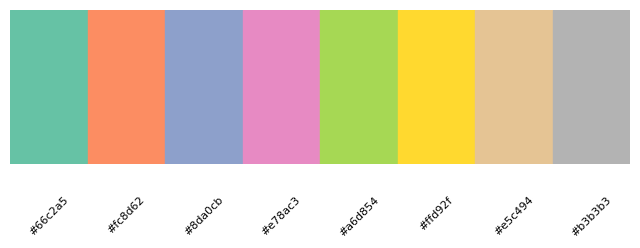

In [5]:
# Define the colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', 
          '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 2))

# Plot each color as a square
for i, color in enumerate(colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    ax.text(i + 0.5, -0.2, color, ha='center', va='top', fontsize=8, rotation=45)

# Formatting
ax.set_xlim(0, len(colors))
ax.set_ylim(0, 1)
ax.axis('off')


In [14]:
#lets set these colors as the colors for the fake data for th skething analysis 
visium_complex_adata.uns['group_colors'] = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', 
          '#a6d854', '#ffd92f']

In [29]:
group_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']
output_dir = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/"
# Plot each dataset
for name, adata in datasets.items():
    adata.uns['group_colors'] = group_colors

    fig, ax = plt.subplots(figsize=(24, 16))
    sq.pl.spatial_scatter(adata, color="group", shape=None, ax=ax, size=2)
    
    # Remove legend and other plot elements
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    # Save the plot
    save_path = os.path.join(output_dir, f"{name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


In [31]:
group_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']
output_dir = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/"
# Plot each dataset
for name, adata in datasets.items():
    adata.uns['group_colors'] = group_colors

    fig, ax = plt.subplots(figsize=(24, 16))
    sq.pl.spatial_scatter(adata, color="foldchange", shape=None, ax=ax, size=2)
    
    # Remove legend and other plot elements
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    # Save the plot
    save_path = os.path.join(output_dir, f"foldchange_{name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

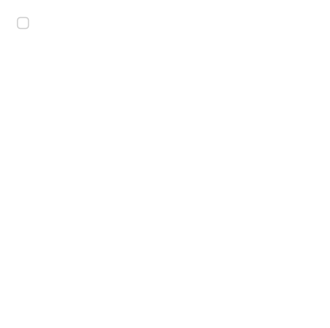

In [32]:
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

legend_fig, legend_ax = plt.subplots(figsize=(4, 4))  # Adjust size as needed

# Extract handles and labels from the axes of the scatter plot
handles, labels = ax.get_legend_handles_labels()

# Create the legend in the new figure
legend_ax.legend(handles, labels, loc='upper left')  # You can choose the location you prefer

# Hide axes for the legend
legend_ax.axis('off')
plt.savefig('/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/foldchange_labels.svg', format = 'svg',dpi=300, bbox_inches='tight')
# Show the legend figure
plt.show()

In [27]:
dataset_string = "xenium_like_data/stripes"
dataset_name = "xenium_like_data_stripes"

In [28]:
#now we need to take a look at the full metrics 
#lets start with just a single dataset for now! 
from glob import glob
#now for the line plots: 
#first get the metric csvs 
directory = f"/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/simulations_for_sketching_analysis/{dataset_string}/sketching_test/combined_metrics"

# Use glob to find all .csv files in the specified directory
csv_files = glob(os.path.join(directory, '*.csv'))

# Initiate an empty list to store DataFrames
dataframes = []

# Iterate over each file path in the list of CSV files
for file in csv_files:
    # Read each CSV file into a DataFrame
    df = pd.read_csv(file)
    # Append the DataFrame to the list
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
metrics_df = pd.concat(dataframes, ignore_index=True)

#read in the specific knn neighborhood analysis file: 
directory = f'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/simulations_for_sketching_analysis/{dataset_string}/sketching_test/knn_neighborhood_analysis'
csv_files = glob(os.path.join(directory, '*.csv'))

# Initiate an empty list to store DataFrames
dataframes = []

# Iterate over each file path in the list of CSV files
for file in csv_files:
    # Read each CSV file into a DataFrame
    df = pd.read_csv(file)
    # Append the DataFrame to the list
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
knn_df = pd.concat(dataframes, ignore_index=True)


In [8]:
knn_df['method'].unique()

array(['geo_transcriptomic', 'leverage', 'scsampler_transcriptomic',
       'uniform', 'rasp_geo', 'rasp_scsampler', 'rasp_leverage',
       'leverage_svd', 'leverage_svd_smoothed'], dtype=object)

In [29]:
methods = [
    'uniform', 'leverage', 'leverage_svd','leverage_svd_smoothed',
    'scsampler_coord', 'scsampler_transcriptomic', 'rasp_scsampler', 
    'geo_coords', 'geo_transcriptomic', 'rasp_geo'
]
knn_df_sub = knn_df[
    (knn_df['fraction']<1)&
    (knn_df['method'].isin(methods)&(knn_df['knn_for_neighborhood_analysis']==10))]

grouped = knn_df_sub.groupby(['method', 'fraction'])['mse'].count().reset_index()

for method in methods:
    for frac in sorted(knn_df_sub['fraction'].unique()):
        # Get the count of non-null mse for this method and fraction
        count = grouped[(grouped['method'] == method) & (grouped['fraction'] == frac)]['mse']
        count = count.values[0] if not count.empty else 0
        if count < 10:
            print(f"method: {method} is missing {10-count} values from mse for fraction {frac}")

In [9]:

all_methods = [
    'uniform', 'leverage', 'leverage_svd','leverage_svd_smoothed',
    'scsampler_coord', 'scsampler_transcriptomic', 'rasp_scsampler', 
    'geo_coords', 'geo_transcriptomic', 'rasp_geo'
]

# Get 'Set2' colors for the methods
palette = sns.color_palette("Set2", len(all_methods))

# Create the color mapping
color_dict = dict(zip(all_methods, palette))

# Update the last method's color to the specified hex
color_dict[all_methods[-2]] = "#bc80bd"
color_dict[all_methods[-1]] = "#80b1d3"



# Check the color mapping
for method, color in color_dict.items():
    print(f'Method: {method}, Color: {color}')

Method: uniform, Color: (0.4, 0.7607843137254902, 0.6470588235294118)
Method: leverage, Color: (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
Method: leverage_svd, Color: (0.5529411764705883, 0.6274509803921569, 0.796078431372549)
Method: leverage_svd_smoothed, Color: (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)
Method: scsampler_coord, Color: (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)
Method: scsampler_transcriptomic, Color: (1.0, 0.8509803921568627, 0.1843137254901961)
Method: rasp_scsampler, Color: (0.8980392156862745, 0.7686274509803922, 0.5803921568627451)
Method: geo_coords, Color: (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)
Method: geo_transcriptomic, Color: #bc80bd
Method: rasp_geo, Color: #80b1d3


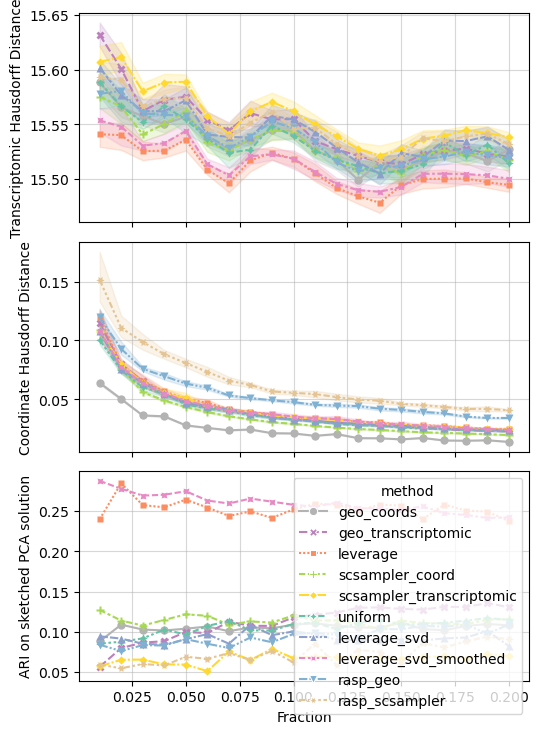

In [40]:
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)

cutoff = 0.3
line_thickness = 1.5

methods1 = ['uniform', 'leverage', 'leverage_svd','leverage_svd_smoothed',
            'geo_coords', 'geo_transcriptomic','rasp_geo','scsampler_transcriptomic',
            'scsampler_coord','rasp_scsampler']
# Filter the dataset
combined_df1 = metrics_df[
    (metrics_df['fraction'] < cutoff) & 
    (metrics_df['method'].isin(methods1))
]

knn_sub1 = knn_df[
    (knn_df['fraction']<cutoff)&
    (knn_df['method'].isin(methods1))]


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5.5, 7.7))
axes = axes.flatten()
# Define common plot settings
plot_kwargs1 = {
    "data": combined_df1, "x": "fraction", "hue": "method", 
    "palette": color_dict, "alpha": 1, "linewidth": line_thickness,
    "markers": True, "style": "method"
}

# Define common plot settings
# plot_kwargs2 = {
#     "data": combined_df2, "x": "fraction", "hue": "method", 
#     "palette": color_dict, "alpha": 0.5, "linewidth": line_thickness,
#     "markers": True, "style": "method"
# }

# Plot each metric
sns.lineplot(y="transcriptomic_distance", ax=axes[0], **plot_kwargs1,legend = False)
axes[0].set_ylabel("Transcriptomic Hausdorff Distance")

sns.lineplot(y="coord_distance", ax=axes[1], **plot_kwargs1,legend = False)
axes[1].set_ylabel("Coordinate Hausdorff Distance")

sns.lineplot(y="ari_recomputed_pca", ax=axes[2], **plot_kwargs1,legend = True)
axes[2].set_ylabel("ARI on sketched PCA solution")

axes[0].set_xlabel('')
axes[0].tick_params(labelbottom=False)
axes[1].set_xlabel('')
axes[1].tick_params(labelbottom=False)

# Optionally, set the x-axis label only on the last plot
axes[2].set_xlabel("Fraction")  # or any x-axis label you want


for ax in axes:
    #ax.set_xlabel("Fraction")
    ax.grid(True, alpha=0.5)
    for line in ax.lines:
        line.set_markeredgecolor('none')
plt.tight_layout()


plt.savefig(f'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/{dataset_name}_main_metrics_0.2.svg', 
            format='svg', dpi=300)
plt.show()




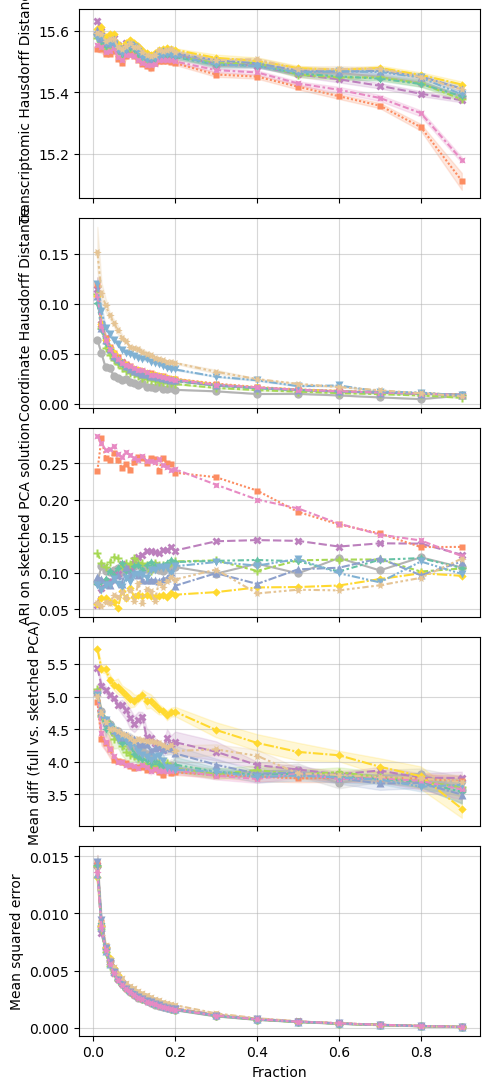

In [30]:
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)


line_thickness = 1.5
#now we need to save the full range of fractions 0.01 to 0.9 and move to the suppliment
methods1 = ['uniform', 'leverage', 'leverage_svd','leverage_svd_smoothed',
            'geo_coords', 'geo_transcriptomic','rasp_geo','scsampler_transcriptomic',
            'scsampler_coord','rasp_scsampler']
# Filter the dataset
combined_df1 = metrics_df[
    (metrics_df['fraction'] < 1) & 
    (metrics_df['method'].isin(methods1))
]

knn_sub1 = knn_df[
    (knn_df['fraction']<1)&
    (knn_df['method'].isin(methods1)&(knn_df['knn_for_neighborhood_analysis']==10))]


fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5, 11))
axes = axes.flatten()
# Define common plot settings
plot_kwargs1 = {
    "data": combined_df1, "x": "fraction", "hue": "method", 
    "palette": color_dict, "alpha": 1, "linewidth": line_thickness,
    "markers": True, "style": "method"
}

plot_kwargs2 = {
    "data": knn_sub1, "x": "fraction", "hue": "method", 
    "palette": color_dict, "alpha": 1, "linewidth": line_thickness,
    "markers": True, "style": "method"
}


# Define common plot settings
# plot_kwargs2 = {
#     "data": combined_df2, "x": "fraction", "hue": "method", 
#     "palette": color_dict, "alpha": 0.5, "linewidth": line_thickness,
#     "markers": True, "style": "method"
# }

# Plot each metric
sns.lineplot(y="transcriptomic_distance", ax=axes[0], **plot_kwargs1,legend = False)
axes[0].set_ylabel("Transcriptomic Hausdorff Distance")

sns.lineplot(y="coord_distance", ax=axes[1], **plot_kwargs1,legend = False)
axes[1].set_ylabel("Coordinate Hausdorff Distance")

sns.lineplot(y="ari_recomputed_pca", ax=axes[2], **plot_kwargs1,legend = False)
axes[2].set_ylabel("ARI on sketched PCA solution")


sns.lineplot(y="pca_mean_diff", ax=axes[3], **plot_kwargs1,legend = False)
axes[3].set_ylabel("Mean diff (full vs. sketched PCA)")

sns.lineplot(y="mse", ax=axes[4], **plot_kwargs2,legend = False)
axes[4].set_ylabel("Mean squared error")

axes[0].set_xlabel('')
axes[0].tick_params(labelbottom=False)
axes[1].set_xlabel('')
axes[1].tick_params(labelbottom=False)
axes[2].set_xlabel('')
axes[2].tick_params(labelbottom=False)
axes[3].set_xlabel('')
axes[3].tick_params(labelbottom=False)
# Optionally, set the x-axis label only on the last plot
axes[4].set_xlabel("Fraction")  # or any x-axis label you want
plt.tight_layout()


for ax in axes:
    #ax.set_xlabel("Fraction")
    ax.grid(True, alpha=0.5)
    for line in ax.lines:
        line.set_markeredgecolor('none')
plt.tight_layout()

plt.savefig(f'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/plots/temp/{dataset_name}_suppliment_metrics.svg', 
            format='svg', dpi=300)
plt.show()
